In [19]:
%matplotlib inline
import torch
import torch_geometric as tg
import torch.nn.functional as F
from torch import nn
from torch_geometric.loader import DataLoader
from torch_scatter import scatter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import re
import os
from tqdm import tqdm
from itertools import combinations

from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc, confusion_matrix
from pymatgen.core.structure import Structure
from pymatgen.core.periodic_table import Element

from plot_imports import *
from periodic_table import fetch_table, periodic_plot
from utils import (get_species, load_data, get_roc, get_optimal_threshold, plot_roc, plot_precision_recall_fscore,
                   get_element_results)

seed = 14
torch.set_default_dtype(torch.float64)
torch.manual_seed(seed)
np.random.seed(seed)

# format progress bar
bar_format = '{l_bar}{bar:10}{r_bar}{bar:-10b}'
tqdm.pandas(bar_format=bar_format)

In [42]:
# reload a module without kernel restart
from importlib import reload
import sys
reload(sys.modules['plot_imports'])
reload(sys.modules['periodic_table'])
reload(sys.modules['utils'])
from plot_imports import *
from periodic_table import fetch_table, periodic_plot
from utils import (get_species, load_data, get_roc, get_optimal_threshold, plot_roc, plot_precision_recall_fscore,
                   get_element_results)

### Read and process data

In [2]:
data_path = 'data/data_merged.csv'
energy_path = 'data/xas_energy_merged.p'

if not os.path.exists('models'):
    os.makedirs('models')
        
if not os.path.exists('images'):
    os.makedirs('images')

In [3]:
num_classes = 2
data, species_tot = load_data(data_path, num_classes)

number of samples: 14830
distinct atomic species: 70


In [4]:
# exclude select samples
data_inc = data[data['tag'] == 'INC'].reset_index(drop=True)
print('number of inconclusive samples:', len(data_inc))

data_weyl = data[data['tag'] == 'WEYL'].reset_index(drop=True)
print('number of weyl semimetal samples:', len(data_weyl))

data = data[data['tag'].isna()].reset_index(drop=True)
print('number of train/valid/test samples:', len(data))

species = get_species(data)

number of inconclusive samples: 1617
number of weyl semimetal samples: 13
number of train/valid/test samples: 13151
distinct atomic species: 63


### Analyze and split data

In [5]:
# either compute train/valid/test split or read in computed indices
%matplotlib inline
split = False

if split:
    # compute train/valid/test split
    idx_train, idx_valid, idx_test = train_valid_test_split(data, species, valid_size=0.1, test_size=0.1, seed=seed)
    
else:
    # load computed train/valid/test split
    with open('data/idx_train.txt', 'r') as f:
        idx_train = [int(i.split('\n')[0]) for i in f.readlines()]
        
    with open('data/idx_valid.txt', 'r') as f:
        idx_valid = [int(i.split('\n')[0]) for i in f.readlines()]
        
    with open('data/idx_test.txt', 'r') as f:
        idx_test = [int(i.split('\n')[0]) for i in f.readlines()]

### Prepare data

In [6]:
# one-hot encoding atom type
Z = [Element(specie).Z for specie in species_tot]
n_type = max(Z)

type_encoding = {}
for z in range(1, n_type + 1):
    specie = Element.from_Z(z)
    type_encoding[specie.symbol] = z - 1

type_onehot = torch.eye(len(type_encoding))

In [7]:
# standardize spectra
species_dict = dict(zip(species_tot, [[] for k in range(len(species_tot))]))
for entry in data.iloc[idx_train].itertuples():
    for specie, xas in entry.spectra_abs.items():
        species_dict[specie] += [xas['y'].copy()]
        
for specie in species_tot:
    try: xas = np.stack(species_dict[specie], axis=0)
    except:
        species_dict[specie] = {'mu': np.nan, 's': np.nan}
    else:
        if len(species_dict[specie]) > 1:
            species_dict[specie] = {'mu': xas.mean(axis=1).mean(), 's': xas.std(axis=1).mean()}
        elif len(species_dict[specie]) == 1:
            species_dict[specie] = {'mu': xas.mean(), 's': 1.}

def standardize_xas(x):
    keys = list(x.keys())
    y = dict.fromkeys(keys)
    for specie in keys:
        if np.isnan(species_dict[specie]['mu']):
            y[specie] = np.zeros(np.array(x[specie]['y']).shape)
        else:
            y[specie] = (np.array(x[specie]['y']) - species_dict[specie]['mu'])/species_dict[specie]['s']
    return y

data['spectra_standard'] = data['spectra_abs'].progress_map(lambda x: standardize_xas(x))

100%|██████████| 13151/13151 [00:01<00:00, 8022.55it/s]                         


In [8]:
# format data
class DataSet(tg.data.Data):
    def __init__(self, x, y, edge_index=None, edge_type=None, z=None):
        super(DataSet, self).__init__(x=x, y=y, edge_index=edge_index, edge_type=edge_type, z=z)

def build_data(r):
    elems = list(r.spectra_standard.keys())
    spect = np.stack(list(r.spectra_standard.values()))
    x = torch.tensor(spect)
    
    z = type_onehot[[type_encoding[specie] for specie in elems]]
    
    y = torch.tensor([r.class_true], dtype=float)  
    edge_type = torch.LongTensor([type_encoding[specie] for specie in elems])
    return DataSet(x=x, y=y, z=z, edge_type=edge_type)

data['data'] = data.progress_apply(build_data, axis=1)

100%|██████████| 13151/13151 [00:02<00:00, 4814.10it/s]                         


In [9]:
# configure dataloaders
device = "cuda:6"
batch_size = 64
dataloader_train = DataLoader(data.iloc[idx_train]['data'].tolist(), batch_size=batch_size, shuffle=True)
dataloader_valid = DataLoader(data.iloc[idx_valid]['data'].tolist(), batch_size=batch_size, shuffle=False)
dataloader_test = DataLoader(data.iloc[idx_test]['data'].tolist(), batch_size=batch_size, shuffle=False)

print('number of training batches:', len(dataloader_train))
print('number of validation batches:', len(dataloader_valid))
print('number of testing batches:', len(dataloader_test))

number of training batches: 165
number of validation batches: 21
number of testing batches: 21


In [10]:
# class weights
y_train = data.iloc[idx_train]['data'].map(lambda x: x['y'].item()).tolist()
y_valid = data.iloc[idx_valid]['data'].map(lambda x: x['y'].item()).tolist()
y_test = data.iloc[idx_test]['data'].map(lambda x: x['y'].item()).tolist()
class_weights = []
for k in range(num_classes):
    class_weights += [y_train.count(k)]
    print("class:", k)
    print("total:", (y_train + y_valid + y_test).count(k))
    print("train:", class_weights[k])
    print("valid:", y_valid.count(k))
    print("test:", y_test.count(k), "\n")
class_weights = [1./k for k in class_weights]
cw_mean = np.mean(class_weights)
class_weights = torch.tensor([k/cw_mean for k in class_weights])
print("class weights:", class_weights)
class_weights = class_weights.to(device)

class: 0
total: 8194
train: 6557
valid: 817
test: 820 

class: 1
total: 4957
train: 3949
valid: 509
test: 499 

class weights: tensor([0.7518, 1.2482])


### Train network

In [13]:
class GraphNN(nn.Module):
    def __init__(self, length, embed_dim, hidden_dim, num_dense, num_classes, class_weights=None, slope=0.01, drop=0,
                 scale=2, reduce=True, type_only=False):
        super(GraphNN, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        self.class_weights = class_weights
        self.reduce = reduce
        self.type_only = type_only
        
        try: len(class_weights)
        except: self.pos_weight = None
        else: self.pos_weight = self.class_weights[1]/self.class_weights[0]
        
        # atom type embedding
        self.embed = nn.Linear(in_features=n_type, out_features=embed_dim)
        
        if not self.type_only:
            # fully-connected
            self.fc = self.linear_block_chain(length, hidden_dim, num_dense-1, slope, drop, scale)
        
        # fully-connected
        self.fcc = self.linear_block_chain(hidden_dim*embed_dim, hidden_dim, num_dense-1, slope, drop, scale)
        
        # symmetry
        self.sc = nn.Linear(in_features=hidden_dim, out_features=7)
        
        # classifier
        if num_classes == 2:
            self.classifier = nn.Linear(in_features=hidden_dim, out_features=1)
        else:
            self.classifier = nn.Linear(in_features=hidden_dim, out_features=num_classes)
    
    def linear_block_chain(self, in_features, hidden_dim, num_dense, slope, drop=0, scale=2):
        
        if in_features < hidden_dim: shift = -(num_dense - 1)
        else: shift = num_dense - 1
            
        out_features = (np.logspace(np.log10(hidden_dim)/np.log10(scale),
                                    np.log10(hidden_dim)/np.log10(scale) + shift,
                                    num_dense, base=scale)[::-1]).astype(int)
        
        modules = []
        for i in range(num_dense):
            modules.append(
                nn.Sequential(*self.linear_block(in_features, out_features[i], slope, drop)))
            in_features = out_features[i]
        
        return nn.Sequential(*modules)
    
    def linear_block(self, in_features, out_features, slope, drop=0):
        modules = [nn.Linear(in_features=in_features, out_features=out_features)]
        
        if drop: modules.append(nn.Dropout(p=drop))
        modules.append(nn.LeakyReLU(negative_slope=slope))
        
        return modules
        
    def loss_function(self, y_pred, y_true):
        return nn.BCEWithLogitsLoss(pos_weight=self.pos_weight)(y_pred, y_true)
    
    def get_score(self, y):
        return torch.sigmoid(y)
        
    def get_class(self, y, th=0.5):
        return (self.get_score(y) >= th).float()

    def accuracy(self, y_pred, y_true):
        y_pred_class = self.get_class(y_pred)
        y_corr = (y_pred_class == y_true).float()
        acc = y_corr.sum()/len(y_corr)*100.
        return acc
    
    def process(self, data):
        # embed z
        z = self.embed(data.z)
        
        # spectrum transformation
        if self.type_only:
            x = torch.ones((z.size()[0], self.hidden_dim), device=z.device)
        else:
            x = self.fc(data.x)
        
        # outer product with atom type
        x = torch.einsum('bi,bj->bij', (z, x))
        
        # aggregate spectra
        if self.reduce:
            x = scatter(x, data.batch, dim=0, reduce='sum')
        
        return x
    
    def forward(self, data):
        # process spectra
        x = self.process(data)
        
        # unravel channels
        x = x.flatten(start_dim=1)
        
        # feed-forward
        x = self.fcc(x)
        
        # classification
        return self.classifier(x).squeeze()

In [44]:
# instantiate model
length = 200
width = 128
embed_dim = n_type
hidden_dim = 64
num_dense = 3
slope = 0.01
drop = 0.5
scale_dense = 4
reduce = True
type_only = False

model = GraphNN(length, embed_dim, hidden_dim, num_dense, num_classes, class_weights, slope, drop,
                scale_dense, reduce, type_only).to(device)

opt = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.)
print(model)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

GraphNN(
  (embed): Linear(in_features=93, out_features=93, bias=True)
  (fcc): Sequential(
    (0): Sequential(
      (0): Linear(in_features=5952, out_features=256, bias=True)
      (1): Dropout(p=0.5, inplace=False)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Linear(in_features=256, out_features=64, bias=True)
      (1): Dropout(p=0.5, inplace=False)
      (2): LeakyReLU(negative_slope=0.01)
    )
  )
  (sc): Linear(in_features=64, out_features=7, bias=True)
  (classifier): Linear(in_features=64, out_features=1, bias=True)
)
1549678


In [45]:
# training and evaluation functions
def evaluate(model, dataloader, device):
    model.eval()
    
    loss_cumulative = 0.
    acc_cumulative = 0.
    
    with torch.no_grad():
        for j, d in enumerate(dataloader):
            d.to(device)
            y_pred = model(d)
            loss = model.loss_function(y_pred, d.y).cpu()
                
            acc = model.accuracy(y_pred, d.y).cpu()
            loss_cumulative += loss.detach().item()
            acc_cumulative += acc.detach().item()
        
    return loss_cumulative/len(dataloader), acc_cumulative/len(dataloader)

def train(model, optimizer, dataloader_train, dataloader_valid, dynamics, step_0, max_iter=1000, device="cpu"):
    checkpoint = 5
    
    for step in range(max_iter):
        model.train()
        
        loss_cumulative = 0.
        acc_cumulative = 0.
        start_time = time.time()
        
        for j, d in enumerate(dataloader_train):
            d.to(device)
            y_pred = model(d)
            loss = model.loss_function(y_pred, d.y).cpu()
                
            acc = model.accuracy(y_pred, d.y).cpu()
            
            print(f"Iteration {step+1:5d}    batch {j+1:5d} / {len(dataloader_train):5d}   " +
                  f"batch loss = {loss.data:.7e}", end="\r", flush=True)
            loss_cumulative += loss.detach().item()
            acc_cumulative += acc.detach().item()

            opt.zero_grad()
            loss.backward()
            opt.step()
            
        end_time = time.time()
        wall = end_time - start_time
        
        if (step+1)%checkpoint == 0:
            print(f"Iteration {step+1:5d}    batch {j+1:5d} / {len(dataloader_train):5d}   " +
                  f"epoch loss = {loss_cumulative / len(dataloader_train):.7e}")

            valid_avg_loss = evaluate(model, dataloader_valid, device)
            train_avg_loss = evaluate(model, dataloader_train, device)

            dynamics.append({
                'step': step + step_0,
                'wall': wall,
                'batch': {
                    'loss': loss.item(),
                    'accuracy': acc.item(),
                },
                'valid': {
                    'loss': valid_avg_loss[0],
                    'accuracy': valid_avg_loss[1],
                },
                 'train': {
                     'loss': train_avg_loss[0],
                     'accuracy': train_avg_loss[1],
                 },
            })

            yield {
                'dynamics': dynamics,
                'state': model.state_dict(),
                'optimizer': opt.state_dict()
            }

In [46]:
#model_path = 'models/nn_onehot.torch'
model_path = 'models/nn.torch'

In [47]:
# fit model
resume_fit = False
if resume_fit:
    model.load_state_dict(torch.load(model_path, map_location=device)['state'])
    opt.load_state_dict(torch.load(model_path, map_location=device)['optimizer'])
    dynamics = torch.load(model_path, map_location=device)['dynamics']
    step_0 = dynamics[-1]['step'] + 1
else:
    dynamics = []
    step_0 = 0
    
for results in train(model, opt, dataloader_train, dataloader_valid, dynamics, step_0, max_iter=80, device=device):
    with open(model_path, 'wb') as f:
        torch.save(results, f)

Iteration     5    batch   165 /   165   epoch loss = 4.9658154e-01
Iteration    10    batch   165 /   165   epoch loss = 4.6209333e-01
Iteration    15    batch   165 /   165   epoch loss = 4.4745582e-01
Iteration    20    batch   165 /   165   epoch loss = 4.3481832e-01
Iteration    25    batch   165 /   165   epoch loss = 4.1923854e-01
Iteration    30    batch   165 /   165   epoch loss = 4.0843931e-01
Iteration    35    batch   165 /   165   epoch loss = 3.9580637e-01
Iteration    40    batch   165 /   165   epoch loss = 3.8672946e-01
Iteration    45    batch   165 /   165   epoch loss = 3.8184971e-01
Iteration    50    batch   165 /   165   epoch loss = 3.6570066e-01
Iteration    55    batch   165 /   165   epoch loss = 3.5985837e-01
Iteration    60    batch   165 /   165   epoch loss = 3.5630746e-01
Iteration    65    batch   165 /   165   epoch loss = 3.4940704e-01
Iteration    70    batch   165 /   165   epoch loss = 3.3946508e-01
Iteration    75    batch   165 /   165   epoch l

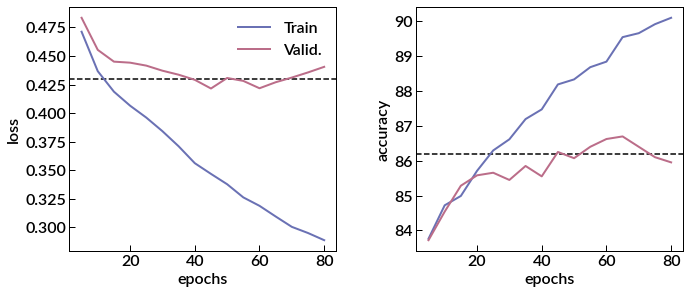

In [48]:
# plot history
%matplotlib inline
saved = torch.load(model_path, map_location=device)
steps = [d['step'] + 1 for d in saved['dynamics']]
loss_train = [d['train']['loss'] for d in saved['dynamics']]
loss_valid = [d['valid']['loss'] for d in saved['dynamics']]
acc_train = [d['train']['accuracy'] for d in saved['dynamics']]
acc_valid = [d['valid']['accuracy'] for d in saved['dynamics']]

fig, ax = plt.subplots(1,2, figsize=(11,4.5))
prop.set_size(16)

ax[0].axhline(np.mean(loss_valid[-10:]), color='black', ls='dashed')
ax[0].plot(steps, loss_train, lw=2, label="Train", color='#6A71B4')
ax[0].plot(steps, loss_valid, lw=2, label="Valid.", color='#BB6D89')

ax[1].axhline(np.mean(acc_valid[-10:]), color='black', ls='dashed')
ax[1].plot(steps, acc_train, lw=2, label="Train", color='#6A71B4')
ax[1].plot(steps, acc_valid, lw=2, label="Valid", color='#BB6D89')

format_axis(ax[0], 'epochs', 'loss', prop, legend=True)
format_axis(ax[1], 'epochs', 'accuracy', prop)
fig.subplots_adjust(wspace=0.3)

In [49]:
# load trained model for prediction
model.load_state_dict(torch.load(model_path, map_location=device)['state'])

<All keys matched successfully>

In [50]:
def evaluate_model(model, dataloader, device, th=None):
    # evaluate trained model over all datasets
    true = np.zeros((len(dataloader.dataset),))
    pred = np.zeros((len(dataloader.dataset),))
    model.eval()
    with torch.no_grad():
        k = 0
        for j, d in enumerate(dataloader):
            d.to(device)
            y_pred = model(d)
            true[k:k + len(y_pred)] = d.y.cpu().numpy()
            
            if th:
                # apply threshold to predicted class
                pred[k:k + len(y_pred)] = model.get_class(y_pred, th=th).cpu().numpy()
            else:
                # get sigmoid-activated class prediction without applied threshold
                pred[k:k + len(y_pred)] = list(torch.sigmoid(y_pred).cpu().numpy())
            k += len(y_pred)
    return true, pred

tpr: 0.8722986247544204 fpr: 0.12362301101591187 th: 0.6248115452331698


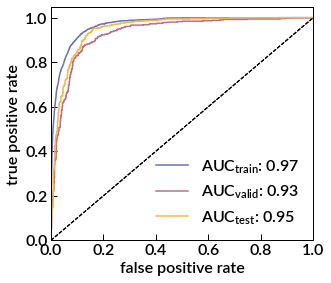

In [51]:
# evaluate performance on all datasets
true_train, pred_train = evaluate_model(model, dataloader_train, device)
true_valid, pred_valid = evaluate_model(model, dataloader_valid, device)
true_test, pred_test = evaluate_model(model, dataloader_test, device)

fpr, tpr, roc_auc, th = [], [], [], []
for y_true, y_pred in zip([true_train, true_valid, true_test], [pred_train, pred_valid, pred_test]):
    fpri, tpri, auci, thi = get_roc(y_pred, y_true)
    fpr += [fpri]
    tpr += [tpri]
    roc_auc += [auci]
    th += [thi]

# get optimal threshold using validation set
tpr0, fpr0, th0 = get_optimal_threshold(fpr[1], tpr[1], th[1])

# plot operating curves
fig, ax = plt.subplots(1,1, figsize=(4.7,4.3))
prop.set_size(16)
plot_roc(ax, fpr, tpr, roc_auc)
ax.legend(loc='lower right', prop=prop, frameon=False);

In [52]:
# evaluate with optimal threshold
true_train, pred_train = evaluate_model(model, dataloader_train, device, th=th0)
true_valid, pred_valid = evaluate_model(model, dataloader_valid, device, th=th0)
true_test, pred_test = evaluate_model(model, dataloader_test, device, th=th0)

accuracy (unweighted): 0.9045307443365695
metric average (weighted): (0.9052492112531864, 0.9045307443365695, 0.9047848317788267, None)
recall: [0.91505262 0.88706002]
precision: [0.9308098  0.86280788]
f1: [0.92286395 0.87476589]


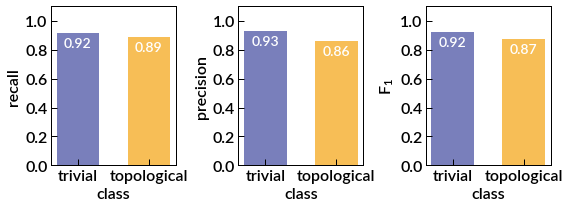

In [53]:
# training data
fig, ax = plt.subplots(1,3, figsize=(8,3))
print('accuracy (unweighted):', np.count_nonzero(true_train == pred_train)/len(true_train))
plot_precision_recall_fscore(ax, true_train, pred_train, num_classes, prop)
fig.tight_layout()
fig.subplots_adjust(wspace=0.5)

accuracy (unweighted): 0.8748114630467572
metric average (weighted): (0.877583258568794, 0.8748114630467572, 0.8755392739927488, None)
recall: [0.87637699 0.87229862]
precision: [0.91677337 0.8146789 ]
f1: [0.89612015 0.84250474]


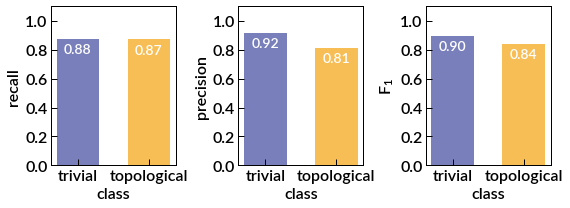

In [54]:
# validation data
fig, ax = plt.subplots(1,3, figsize=(8,3))
print('accuracy (unweighted):', np.count_nonzero(true_valid == pred_valid)/len(true_valid))
plot_precision_recall_fscore(ax, true_valid, pred_valid, num_classes, prop)
fig.tight_layout()
fig.subplots_adjust(wspace=0.5)

accuracy (unweighted): 0.8817285822592873
metric average (weighted): (0.882281587386018, 0.8817285822592873, 0.8819524502778222, None)
recall: [0.89878049 0.85370741]
precision: [0.90987654 0.83693517]
f1: [0.90429448 0.8452381 ]


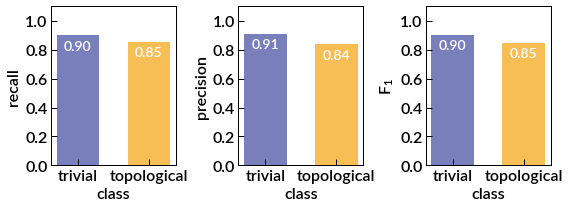

In [55]:
# testing data
fig, ax = plt.subplots(1,3, figsize=(8,3))
print('accuracy (unweighted):', np.count_nonzero(true_test == pred_test)/len(true_test))
plot_precision_recall_fscore(ax, true_test, pred_test, num_classes, prop)
fig.tight_layout()
fig.subplots_adjust(wspace=0.5)

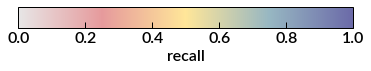

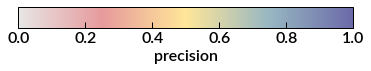

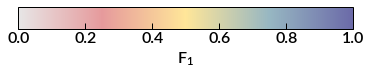

In [43]:
# element specific results for testing data
data_test = data.iloc[idx_test].copy()
data_test['class_pred'] = pred_test.astype(int)
ptable_test = get_element_results(data_test, species)

# save periodic table of element results
cnorm = (0, 1)
for attribute in ['recall_topo', 'precision_topo', 'f1_topo', 'recall_triv', 'precision_triv', 'f1_triv']:
    outfile = 'images/table_' + attribute
    periodic_plot(ptable_test, attribute=attribute, colorby='attribute', cmap=cmap, cnorm=cnorm, output=outfile)

# save periodic table colorbar
for attribute in ['recall', 'precision', '$F_1$']:
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=cnorm[0], vmax=cnorm[1]))    
    sm.set_array([])
    fig, ax = plt.subplots(1,1, figsize=(6,0.4))
    cbar = plt.colorbar(sm, cax=ax, orientation='horizontal')
    fontsize = 16
    format_axis(cbar.ax, xlabel='', ylabel='', prop=prop)
    cbar.ax.tick_params(labelsize=fontsize)
    ax.set_xlabel(attribute, fontsize=fontsize)